In [1]:
import geopandas
import numpy
import geoplanar
from libpysal.graph import Graph
from shapely import Polygon


# Planar Enforcement Violation: non-planar enforced edges

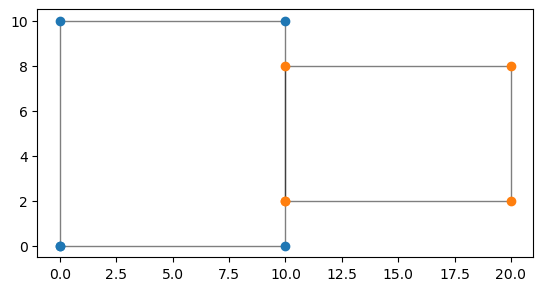

In [2]:
c1 = [[0,0], [0, 10], [10, 10], [10, 0], [0, 0]]
p1 = Polygon(c1)
c2 = [[10, 2], [10, 8], [20, 8], [20, 2], [10, 2]]
p2 = Polygon(c2)
gdf = geopandas.GeoDataFrame(geometry=[p1, p2])
base = gdf.plot(edgecolor='k', facecolor="none",alpha=0.5)
c1 = numpy.array(c1)
c2 = numpy.array(c2)
_ = base.scatter(c1[:,0], c1[:,1])
_ =base.scatter(c2[:,0], c2[:,1])



The two polygons are visually contiguous, but are not planar enforced as the right edge of the left polygon  and the left edge of right polygon  share no vertices. This will result in the two polygons not being Queen neighbors, since a necessary (and sufficient) condition for the latter is at least one shared vertex.

In [3]:
queen = Graph.build_contiguity(gdf, rook=False)
queen.adjacency

focal  neighbor
0      0           0
1      1           0
Name: weight, dtype: int64

## Detecting nonplanar edges

`geoplanar` can detect and report nonplanar edges:

In [4]:
npe = geoplanar.non_planar_edges(gdf)
npe.neighbors

{0: (1,), 1: (0,)}

## Fixing nonplanar edges

In [5]:
geoplanar.is_planar_enforced(gdf)

False

In [6]:
gdf1 = geoplanar.fix_npe_edges(gdf)

In [7]:
npe = geoplanar.non_planar_edges(gdf1)
npe.neighbors

{0: (), 1: ()}

In [8]:
queen = Graph.build_contiguity(gdf1, rook=False)
queen.adjacency

focal  neighbor
0      1           1
1      0           1
Name: weight, dtype: int64

In [9]:
geoplanar.is_planar_enforced(gdf1)

True

## Planar Enforcement Violation: Overlapping and non-planar enforced edges

In [10]:

t1 = Polygon([[0,0],[10,10], [20,0]])

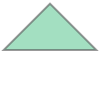

In [11]:
t1

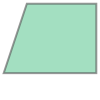

In [12]:
b1 = Polygon([[5,5], [20,5], [20,-10], [0,-10]])
b1

In [13]:
gdf = geopandas.GeoDataFrame(geometry=[t1,b1])

<Axes: >

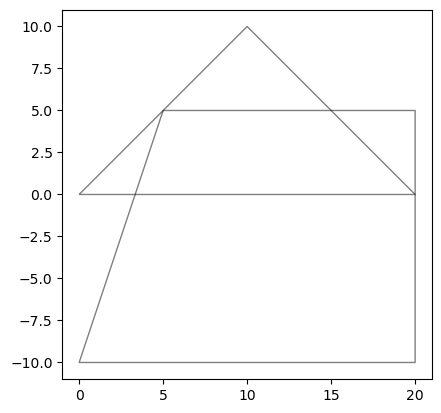

In [14]:
gdf.plot(edgecolor='k',facecolor="none",alpha=0.5) # non planar enforcement


The two features overlap and would appear to share vertices, but they in fact do not share vertices. Again, because this violates planar enforcement, this results in two polygons not being Queen neighbors:

In [15]:
queen = Graph.build_contiguity(gdf, rook=False)
queen.adjacency

focal  neighbor
0      0           0
1      1           0
Name: weight, dtype: int64

## Detecting nonplanar edges

`geoplanar` will use a failed contiguity check as part of a check for nonplanar enforced edges in the polygons of a geoseries:

In [16]:
npe = geoplanar.non_planar_edges(gdf)
npe.neighbors

{0: (1,), 1: (0,)}

## Correcting nonplanar edges

In [17]:
gdf_fixed = geoplanar.fix_npe_edges(gdf)
npe = geoplanar.non_planar_edges(gdf_fixed)
npe.neighbors

ValueError: Polygons are overlapping. Fix overlaps before fixing nonplanar edges.

## Default is to work on a copy

In [19]:
geoplanar.non_planar_edges(gdf)

/Users/serge/miniconda3/envs/edu_concordance/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: 0, 1.
  warnings.warn(message)


defaultdict(set, {0: {1}})

In [20]:
geoplanar.fix_npe_edges(gdf, inplace=True)


,geometry
0,"POLYGON ((0.00000 0.00000, 5.00000 5.00000, 10..."
1,"POLYGON ((5.00000 5.00000, 15.00000 5.00000, 2..."


In [21]:
geoplanar.non_planar_edges(gdf)

defaultdict(set, {})

In [22]:
w = libpysal.weights.Queen.from_dataframe(gdf)
w.neighbors

{0: [1], 1: [0]}

## Handle nonplanar edges in multi polygon case

In [23]:
from shapely.geometry import MultiPolygon

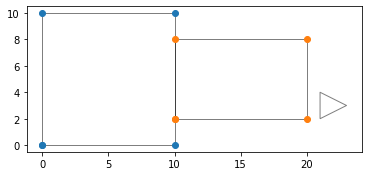

In [24]:
c1 = [[0,0], [0, 10], [10, 10], [10, 0], [0, 0]]
p1 = Polygon(c1)
c2 = [[10, 2], [10, 8], [20, 8], [20, 2], [10, 2]]
p2 = Polygon(c2)
p3 = Polygon([ [21, 2], [21, 4], [23,3] ])
p2 = MultiPolygon([Polygon(c2), p3])
gdf = geopandas.GeoDataFrame(geometry=[p1, p2])
base = gdf.plot(edgecolor='k', facecolor="none",alpha=0.5)
c1 = numpy.array(c1)
c2 = numpy.array(c2)
_ = base.scatter(c1[:,0], c1[:,1])
_ =base.scatter(c2[:,0], c2[:,1])



In [25]:
w = libpysal.weights.Queen.from_dataframe(gdf)

/Users/serge/miniconda3/envs/edu_concordance/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/Users/serge/miniconda3/envs/edu_concordance/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: 0, 1.
  warnings.warn(message)


In [26]:
geoplanar.non_planar_edges(gdf)

defaultdict(set, {0: {1}})

In [27]:
geoplanar.is_planar_enforced(gdf)

False

In [28]:
gdf1 = geoplanar.fix_npe_edges(gdf)

/Users/serge/miniconda3/envs/edu_concordance/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))
/Users/serge/miniconda3/envs/edu_concordance/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: 0, 1.
  warnings.warn(message)


In [29]:
geoplanar.is_planar_enforced(gdf1)

/Users/serge/miniconda3/envs/edu_concordance/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))


True